In [1]:
import os
import json
import numpy as np
import pandas as pd
import torch
from torchvision.io import read_video
from torch.utils.data import Dataset
import ast
from typing import List, Optional, Tuple
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [2]:
!rm -r sample_data/
!pwd
!mkdir data_samples/
!mkdir data_samples/clips

/content


In [ ]:
# metadata
!wget https://raw.githubusercontent.com/kellyjqw/CS381V-project/refs/heads/main/data_samples/descriptions.json -O data_samples/descriptions.json
!wget https://raw.githubusercontent.com/kellyjqw/CS381V-project/refs/heads/main/HowToChange/annotation/train.csv -O data_samples/train.csv
!wget https://raw.githubusercontent.com/kellyjqw/CS381V-project/refs/heads/main/HowToChange/annotation/test.csv -O data_samples/test.csv
!wget https://raw.githubusercontent.com/kellyjqw/CS381V-project/refs/heads/main/HowToChange/annotation/filtered_annotation.csv -O data_samples/annotations.csv

In [ ]:
# video data
!wget https://utexas.box.com/shared/static/dsmzxn48gvibzvprvmoewcdo8ddq9va9.zip -O clips_cropped.zip
!unzip clips_cropped.zip
!mv clips_cropped/* data_samples/clips
!rmdir clips_cropped

In [ ]:
list_files = os.listdir("data_samples/clips") # your directory path
len(list_files)  # Should be 4000+

4786

In [ ]:
class HowToChangeDataLoader(Dataset):
    def __init__(self, split='train'):
        self.base_path = "data_samples"
        self.video_path = os.path.join(self.base_path, "clips")
        self.split = split
        csv_path = os.path.join(self.base_path, f"{self.split}.csv")
        if not os.path.exists(csv_path):
             print(f"Warning: {csv_path} not found. Using dummy data structure.")
             self.annotations = pd.DataFrame(columns=["video_name", "end_intervals", "osc", "duration"])
        else:
            self.annotations = pd.read_csv(csv_path)
            self.annotations["end_intervals"] = self.annotations["end_state"].apply(
              lambda s: ast.literal_eval(s) if isinstance(s, str) else s
            )
            self.annotations["transitioning_intervals"] = self.annotations["transitioning_state"].apply(
              lambda s: ast.literal_eval(s) if isinstance(s, str) else s
            )
            self.annotations["initial_intervals"] = self.annotations["initial_state"].apply(
              lambda s: ast.literal_eval(s) if isinstance(s, str) else s
            )
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        row = self.annotations.iloc[idx]
        video_name = row["video_name"]
        end_intervals = row.get("end_intervals", [])
        transition_intervals = row.get("transitioning_intervals", [])
        initial_intervals = row.get("initial_intervals", [])
        osc = row["osc"]
        try:
            verb, noun = osc.split("_", 1)
        except ValueError:
            verb, noun = "change", "object"

        video_file = os.path.join(self.video_path, f"{video_name}.mp4")

        if not os.path.exists(video_file):
             print(f"Video {video_file} not found.")
             return None

        video, _, info = read_video(video_file, pts_unit="sec")
        frames = video.permute(0, 3, 1, 2)
        num_frames = frames.shape[0]

        fps = info.get("video_fps", 30.0)
        binary_labels = []
        tertiary_labels = []
        four_labels = []
        for i in range(num_frames):
            t = i / fps
            if any((t >= s) and (t <= e) for (s, e) in end_intervals):
                binary_labels.append(1)
                tertiary_labels.append(2)
                four_labels.append(3)
            elif any((t >= s) and (t <= e) for (s, e) in transition_intervals):
                binary_labels.append(0)
                tertiary_labels.append(1)
                four_labels.append(2)
            elif any((t >= s) and (t <= e) for (s, e) in initial_intervals):
                binary_labels.append(0)
                tertiary_labels.append(1)
                four_labels.append(1)
            else:
                binary_labels.append(0)
                tertiary_labels.append(0)
                four_labels.append(0)
        binary_labels = torch.tensor(binary_labels)
        tertiary_labels = torch.tensor(tertiary_labels)
        four_labels = torch.tensor(four_labels)


        return {
            "video_name": video_name,
            "fps": fps,
            "frames": frames,
            "binary_labels": binary_labels,
            "tertiary_labels": tertiary_labels,
            "four_labels": four_labels,
            "osc": osc,
            "verb": verb,
            "noun": noun
        }

In [ ]:
# SKIP GET AND WRITE STEPS if data_distribution_values.json already exists!

# Get set of videos to ignore
def max_segment(segments):
    if not segments:
        return 0.0
    return max(e - s for s, e in segments)

df = pd.read_csv("data_samples/annotations.json")
df['end_state'] = df['end_state'].apply(ast.literal_eval)
df = df[df['end_state'].apply(max_segment) < 0.03 * df['duration']]
ignore_videos = list(set(df['video_name']))

In [ ]:
# Get distribution of binary frames per video
filter_dataset = HowToChangeDataLoader(split='train')

binary_list_num_progress = []
binary_list_prop_progress = []
binary_list_num_end = []
binary_list_prop_end = []

total_count = 0

for sample_idx, sample in enumerate(filter_dataset):
  if sample is None:
    continue
  binary_labels = sample['binary_labels'].float()
  if len(binary_labels) == 0:
    continue
  num_progress = (binary_labels == 0).sum().item()
  binary_list_num_progress.append(num_progress)
  prop_progress = num_progress / len(binary_labels)
  binary_list_prop_progress.append(prop_progress)

  num_end = (binary_labels == 1).sum().item()
  binary_list_num_end.append(num_end)
  prop_end = num_end / len(binary_labels)
  binary_list_prop_end.append(prop_end)
  total_count += 1
  if total_count % 100 == 0:
    print(f"Processed {total_count} videos")

In [ ]:
# Get distribution of tertiary frames per video
filter_dataset = HowToChangeDataLoader(split='train')

list_num_bg = []
list_prop_bg = []
list_num_intermediate = []
list_prop_intermediate = []
list_num_end = []
list_prop_end = []

total_count = 0

for sample_idx, sample in enumerate(filter_dataset):
  if sample is None:
    continue
  tertiary_labels = sample['tertiary_labels'].float()
  if len(tertiary_labels) == 0:
    continue
  num_bg = (tertiary_labels == 0).sum().item()
  list_num_bg.append(num_bg)
  prop_bg = num_bg / len(tertiary_labels)
  list_prop_bg.append(prop_bg)

  num_intermediate = (tertiary_labels == 1).sum().item()
  list_num_intermediate.append(num_intermediate)
  prop_intermediate = num_intermediate / len(tertiary_labels)
  list_prop_intermediate.append(prop_intermediate)

  num_end = (tertiary_labels == 2).sum().item()
  list_num_end.append(num_end)
  prop_end = num_end / len(tertiary_labels)
  list_prop_end.append(prop_end)

  if (num_bg + num_intermediate + num_end) != len(tertiary_labels):
    print("num_bg = ", num_bg)
    print("num_intermediate = ", num_intermediate)
    print("num_end = ", num_end, "\n")
  total_count += 1
  if total_count % 100 == 0:
    print(f"Processed {total_count} videos")

/usr/local/lib/python3.12/dist-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


Processed 100 videos
Processed 200 videos
Processed 300 videos
Processed 400 videos
Processed 500 videos
Processed 600 videos
Processed 700 videos
Processed 800 videos
Processed 900 videos
Processed 1000 videos
Processed 1100 videos
Processed 1200 videos
Processed 1300 videos
Processed 1400 videos
Processed 1500 videos
Processed 1600 videos
Processed 1700 videos
Processed 1800 videos
Processed 1900 videos
Processed 2000 videos
Processed 2100 videos
Processed 2200 videos
Processed 2300 videos
Processed 2400 videos
Processed 2500 videos
Processed 2600 videos
Processed 2700 videos
Processed 2800 videos
Processed 2900 videos
Processed 3000 videos
Processed 3100 videos
Processed 3200 videos
Processed 3300 videos
Processed 3400 videos
Processed 3500 videos
Processed 3600 videos
Processed 3700 videos
Processed 3800 videos
Processed 3900 videos
Processed 4000 videos


In [ ]:
# Write train distribution data to json file
output_lists = {
    "ignore_videos": ignore_videos,
    "binary_num_progress": binary_list_num_progress,
    "binary_prop_progress": binary_list_prop_progress,
    "binary_num_end": binary_list_num_end,
    "binary_prop_end": binary_list_prop_end,
    "tertiary_num_bg": list_num_bg,
    "tertiary_prop_bg": list_prop_bg,
    "tertiary_num_intermediate": list_num_intermediate,
    "tertiary_prop_intermediate": list_prop_intermediate,
    "tertiary_num_end": list_num_end,
    "tertiary_prop_end": list_prop_end
}
output_json = "data_distribution_values.json"
with open(output_json, 'w') as output_json:
  json.dump(output_lists, output_json, indent=4)
print(f"Lists written to {output_json}")

Lists written to <_io.TextIOWrapper name='tertiary_distribution_values.json' mode='w' encoding='utf-8'>


In [ ]:
!wget https://raw.githubusercontent.com/kellyjqw/CS381V-project/refs/heads/main/downstream/data_distribution_values.json -O data_samples/data_distribution_values.json

In [ ]:
# Reading in data distribution file from earlier steps
with open('data_samples/data_distribution_values.json', 'r') as file:
  dist_objects = json.load(file)
print(dist_objects.keys())

ignore_videos = dist_objects.get('ignore_videos')
binary_num_end = dist_objects.get('binary_num_end')
binary_prop_end = dist_objects.get('binary_prop_end')
tertiary_num_bg = dist_objects.get('tertiary_num_bg')
tertiary_prop_bg = dist_objects.get('tertiary_prop_bg')
tertiary_num_intermediate = dist_objects.get('tertiary_num_intermediate')
tertiary_prop_intermediate = dist_objects.get('tertiary_prop_intermediate')
tertiary_num_end = dist_objects.get('tertiary_num_end')
tertiary_prop_end = dist_objects.get('tertiary_prop_end')

dict_keys(['ignore_videos', 'binary_num_end', 'binary_prop_end', 'tertiary_num_bg', 'tertiary_prop_bg', 'tertiary_num_intermediate', 'tertiary_prop_intermediate', 'tertiary_num_end', 'tertiary_prop_end'])


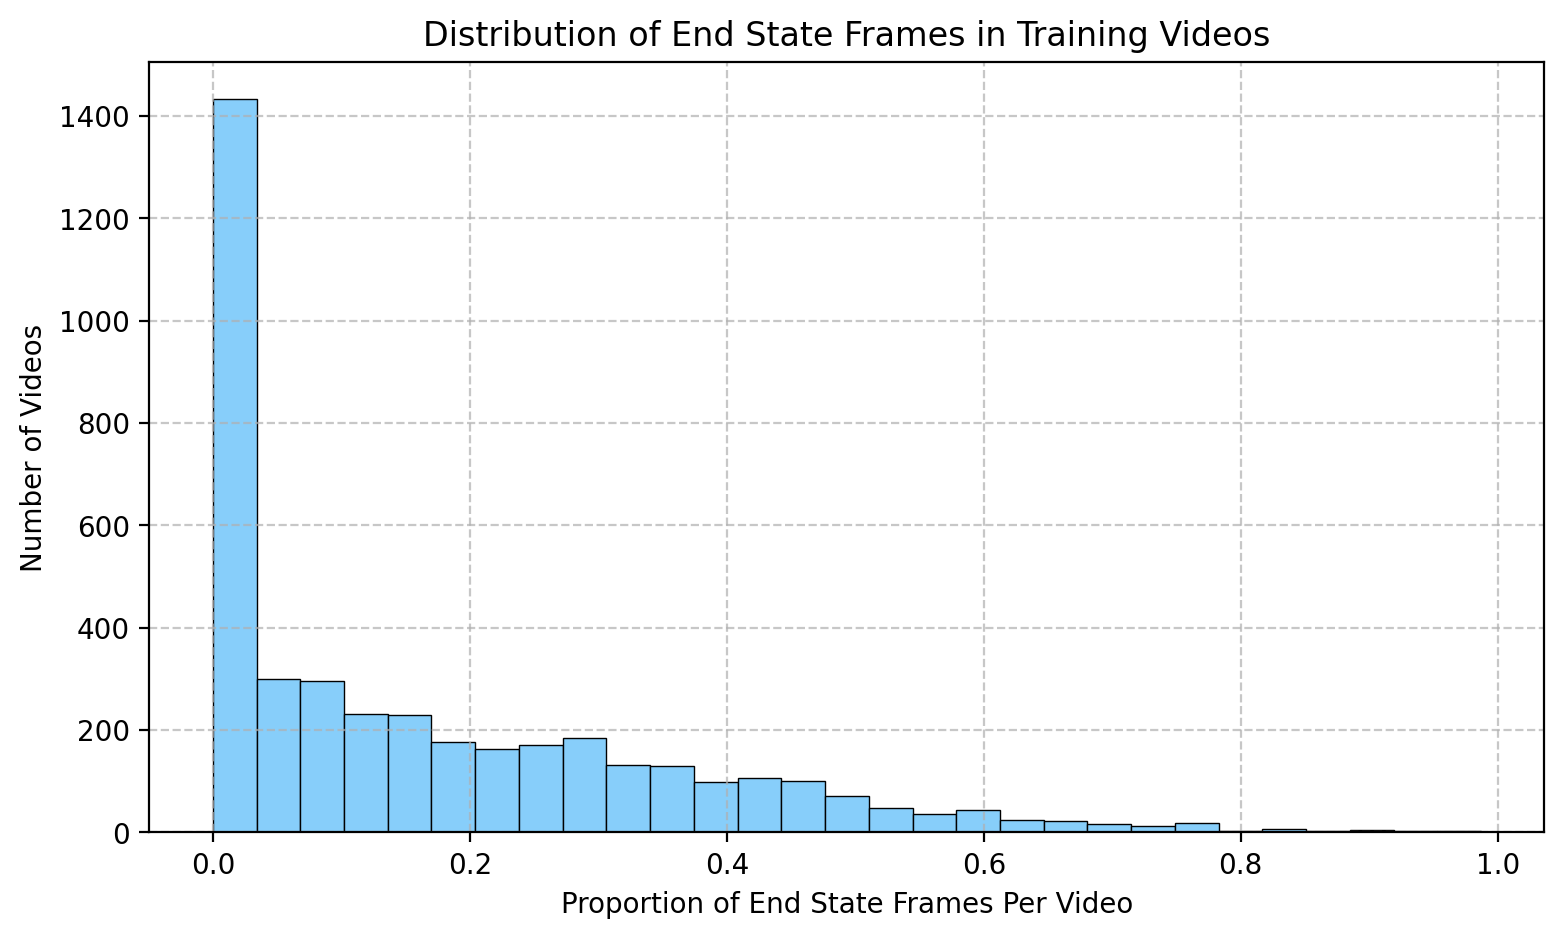

In [ ]:
# Very skewed binary class labels!
plt.rcParams['figure.dpi'] = 200
plt.figure(figsize=(9, 5))
plt.hist(binary_prop_end, bins='auto', color='lightskyblue', edgecolor='black', linewidth=0.5)
plt.title('Distribution of End State Frames in Training Videos')
plt.xlabel('Proportion of End State Frames Per Video')
plt.ylabel('Number of Videos')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

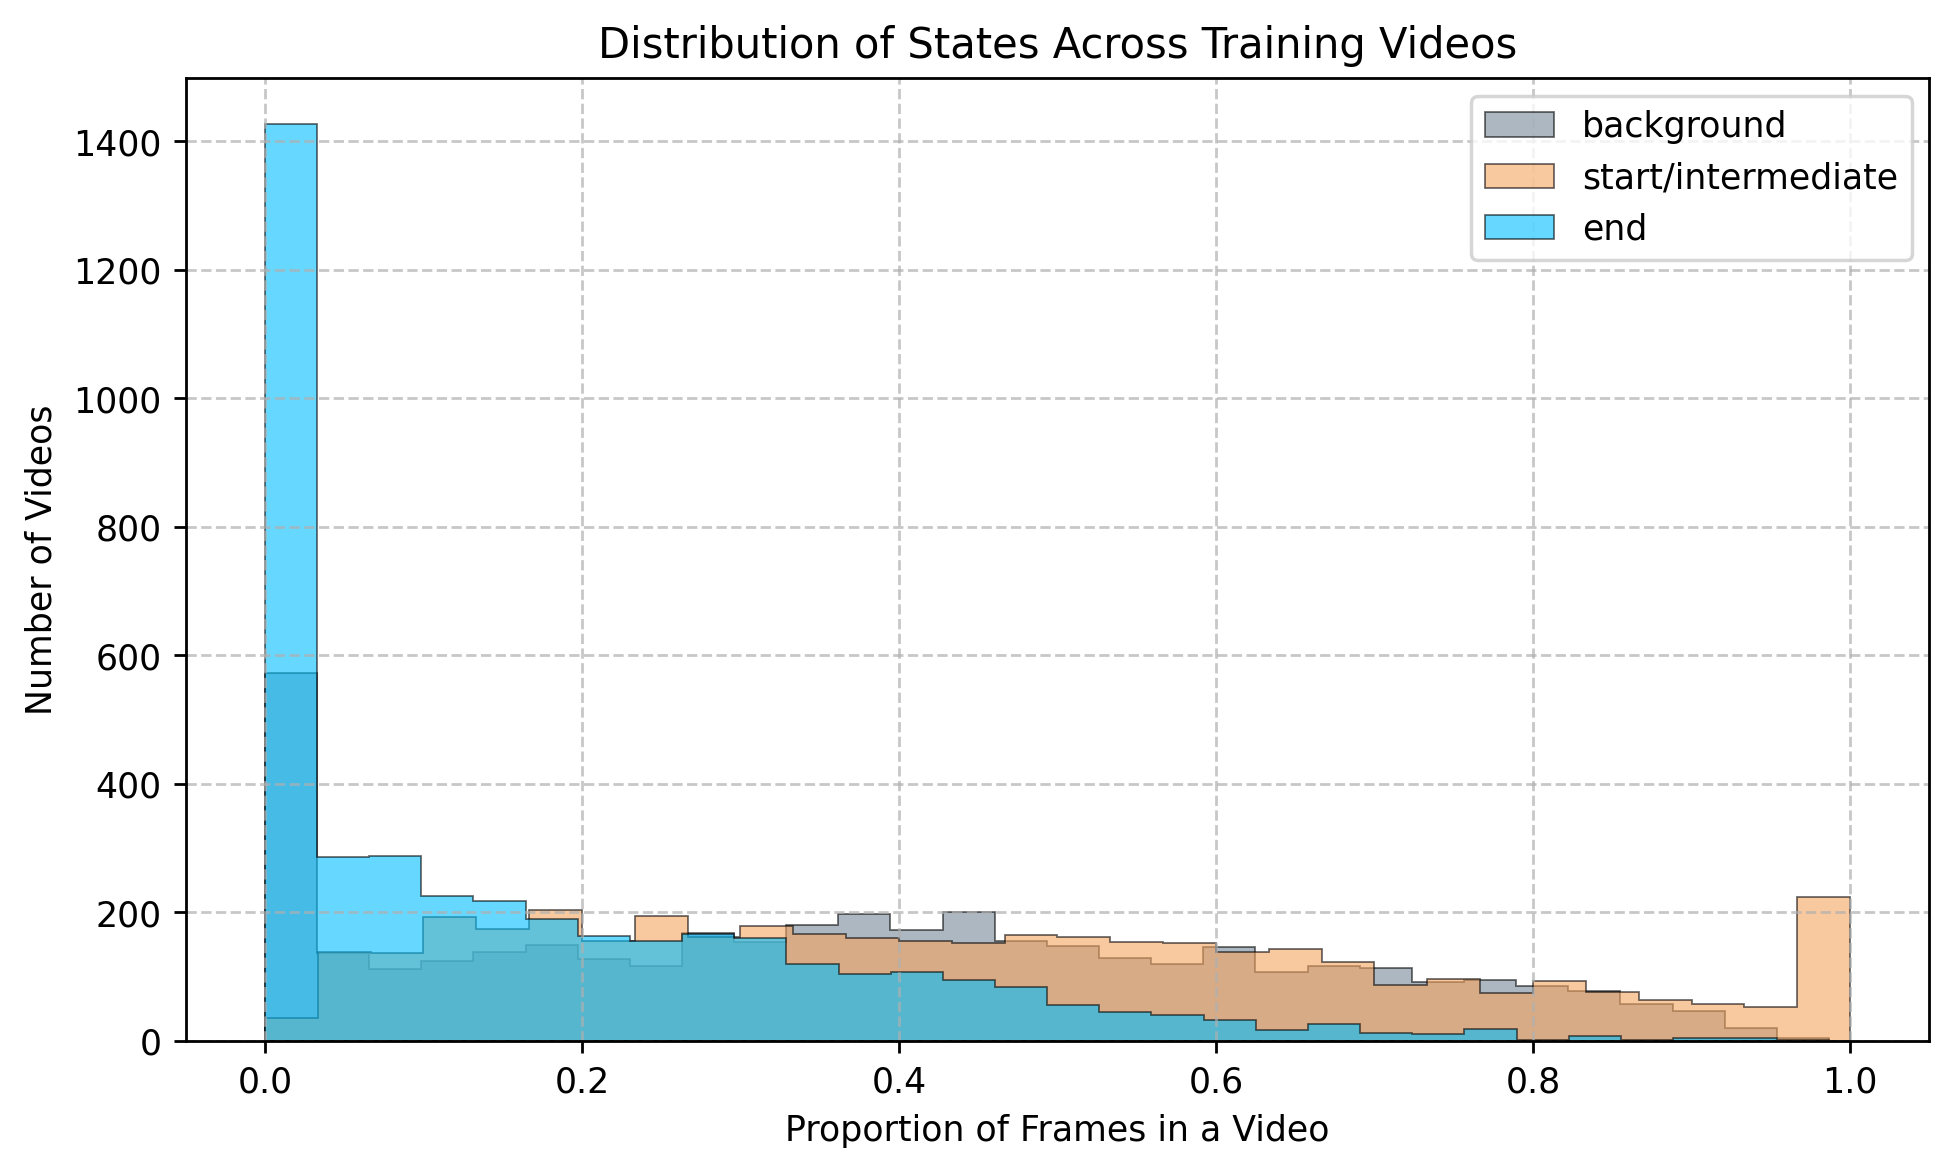

In [ ]:
# Distribution of tertiary frames
plt.rcParams['figure.dpi'] = 250
plt.figure(figsize=(9, 5))

# Colors: skyblue, lightgreen, lightcoral
plt.hist(tertiary_prop_bg, bins=30, alpha=0.6, label='background', color='lightslategrey', histtype='stepfilled',
         edgecolor='black', linewidth=0.5)
plt.hist(tertiary_prop_intermediate, bins=30, alpha=0.6, label='start/intermediate', color='sandybrown',
         histtype='stepfilled', edgecolor='black', linewidth=0.5)
plt.hist(tertiary_prop_end, bins=30, alpha=0.6, label='end', color='deepskyblue', histtype='stepfilled',
         edgecolor='black', linewidth=0.5)

plt.xlabel('Proportion of Frames in a Video')
plt.ylabel('Number of Videos')
plt.title('Distribution of States Across Training Videos')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Duration of tertiary states
def find_durations(segments):
    if not segments:
        return 0.0
    return list(e - s for s, e in segments)

df = pd.read_csv("data_samples/annotations.csv")
background_durations = []
for index, row in df.iterrows():
  intervals = []
  initial_rows = ast.literal_eval(row['initial_state'])
  transition_rows = ast.literal_eval(row['transitioning_state'])
  end_rows = ast.literal_eval(row['end_state'])
  if len(initial_rows) > 0:
    intervals.extend(initial_rows)
  if len(transition_rows) > 0:
    intervals.extend(transition_rows)
  if len(end_rows) > 0:
    intervals.extend(end_rows)
  if len(intervals) == 0:
    continue
  intervals = sorted(intervals, key=lambda x: x[0])
  if intervals[0][0] > 0:
    background_durations.append(intervals[0][0])
  for (s1, e1), (s2, e2) in zip(intervals, intervals[1:]):
      if s2 - e1 > 0:
        background_durations.append(s2 - e1)
  if row['duration'] > intervals[-1][1]:
    background_durations.append(row['duration'] - intervals[-1][1])

df['initial_state'] = df['initial_state'].apply(ast.literal_eval).apply(find_durations)
initial_transition_durations = df['initial_state'].explode().tolist()
df['transitioning_state'] = df['transitioning_state'].apply(ast.literal_eval).apply(find_durations)
transition_durations = df['transitioning_state'].explode().tolist()
initial_transition_durations.extend(transition_durations)
df['end_state'] = df['end_state'].apply(ast.literal_eval).apply(find_durations)
end_durations = df['end_state'].explode().tolist()

print("Background segments: ", len(background_durations))
print("Initial/transition segments: ", len(initial_transition_durations))
print("End segments: ", len(end_durations))

Background segments:  14483
Initial/transition segments:  11514
End segments:  5757


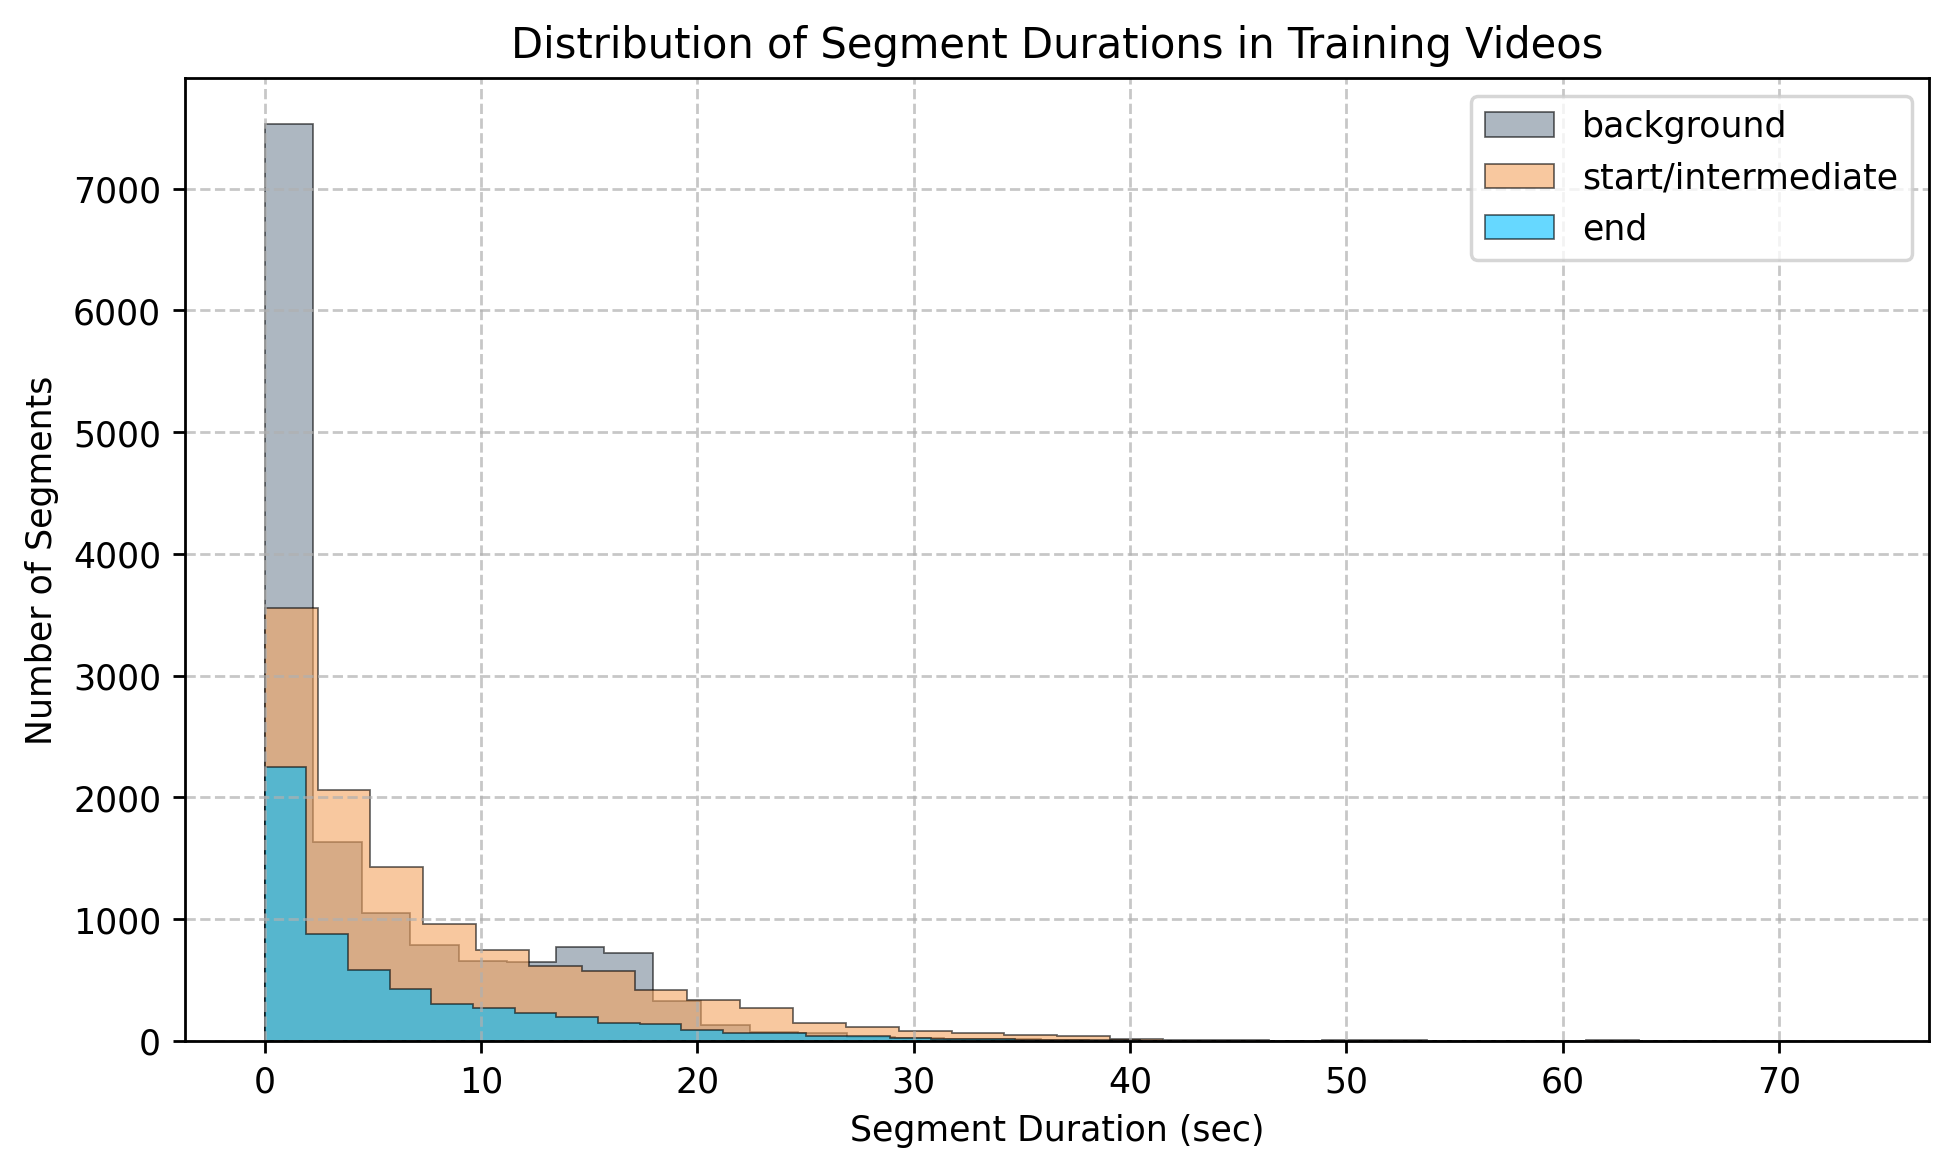

In [ ]:
# Distribution of tertiary
plt.rcParams['figure.dpi'] = 250
plt.figure(figsize=(9, 5))

plt.hist(background_durations, bins=30, alpha=0.6, label='background', color='lightslategrey', histtype='stepfilled',
         edgecolor='black', linewidth=0.5)
plt.hist(initial_transition_durations, bins=30, alpha=0.6, label='start/intermediate', color='sandybrown',
         histtype='stepfilled', edgecolor='black', linewidth=0.5)
plt.hist(end_durations, bins=30, alpha=0.6, label='end', color='deepskyblue', histtype='stepfilled',
         edgecolor='black', linewidth=0.5)

plt.xlabel('Segment Duration (sec)')
plt.ylabel('Number of Segments')
plt.title('Segment Durations in Training Videos')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

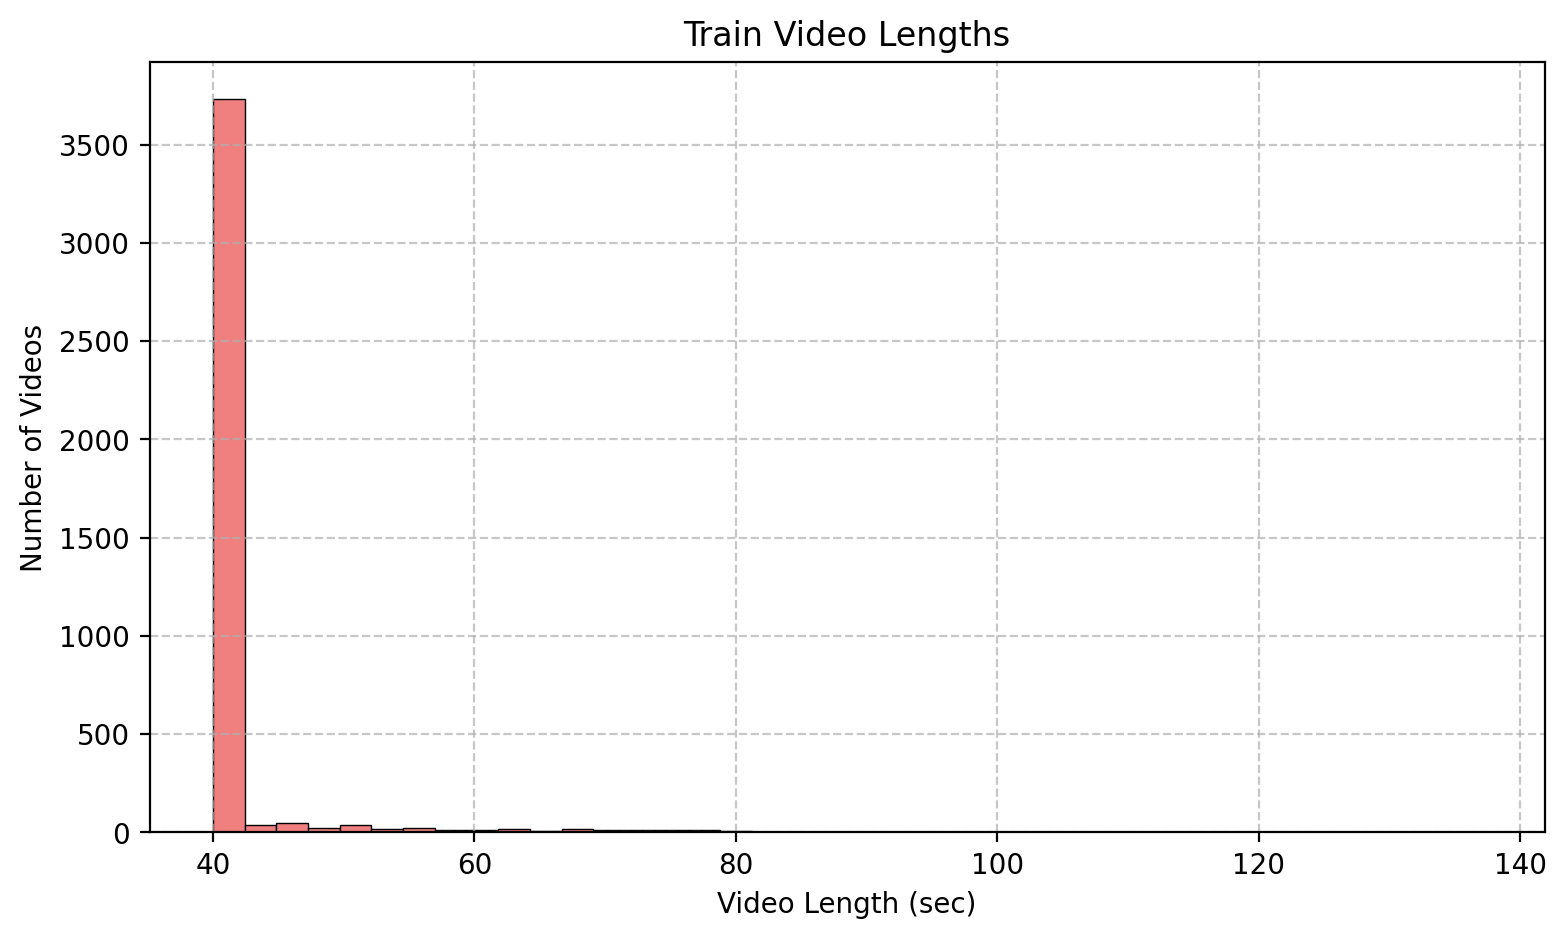

In [10]:
df = pd.read_csv("data_samples/train.csv")
train_durations = df['duration']

# Very skewed binary class labels!
plt.rcParams['figure.dpi'] = 200
plt.figure(figsize=(9, 5))
plt.hist(train_durations, bins=40, color='lightcoral', edgecolor='black', linewidth=0.5)
plt.title('Train Video Lengths')
plt.xlabel('Video Length (sec)')
plt.ylabel('Number of Videos')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

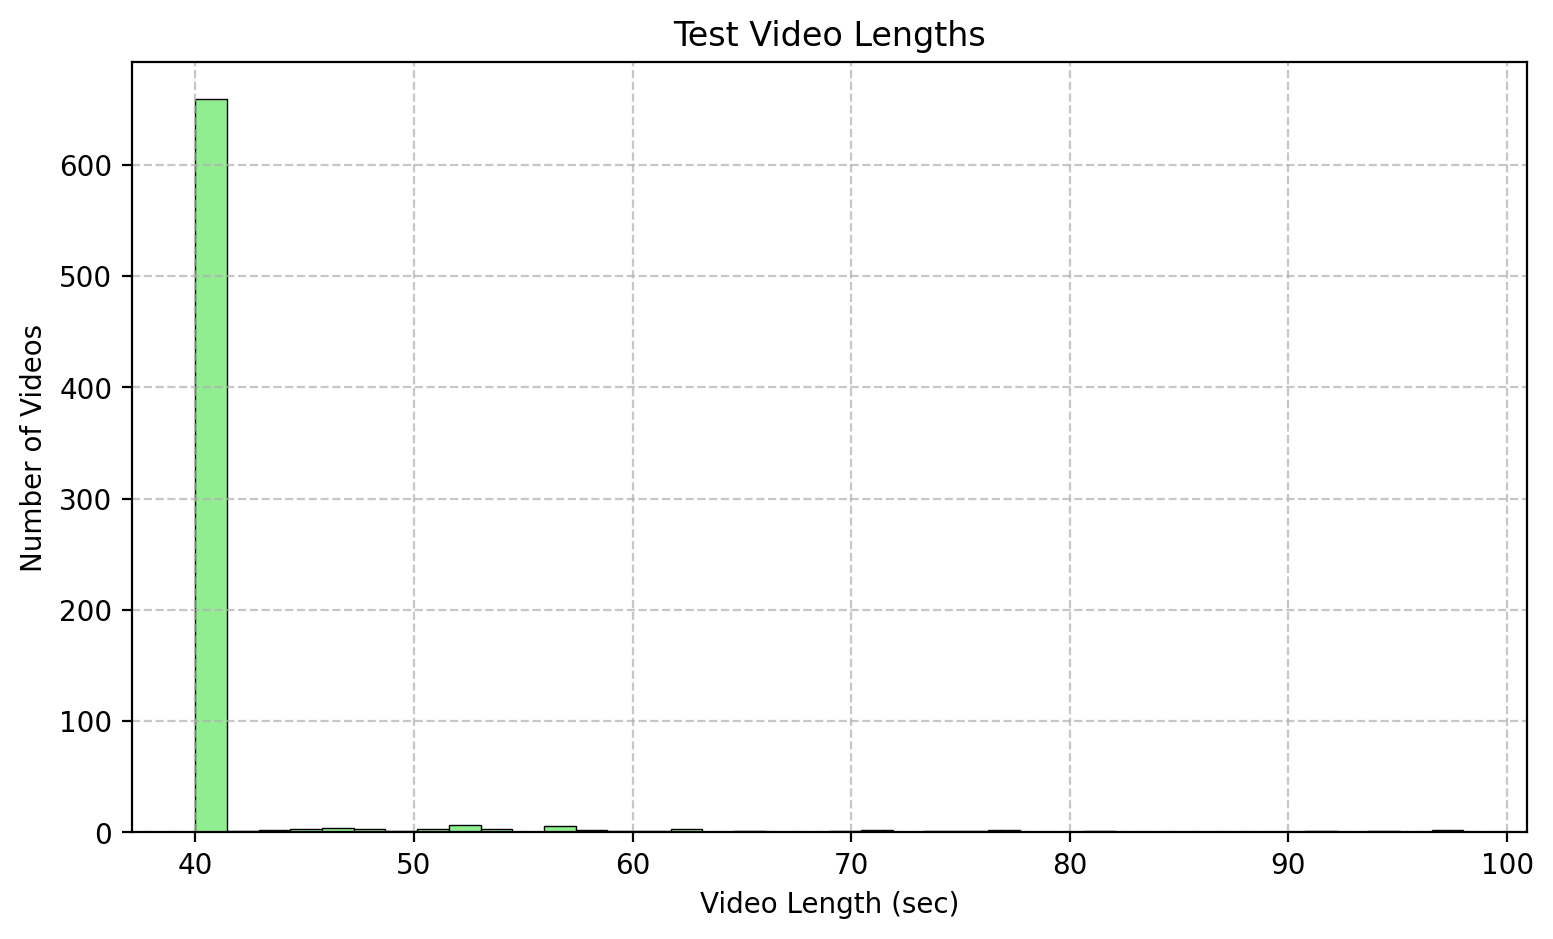

In [9]:
df = pd.read_csv("data_samples/test.csv")
test_durations = df['duration']

# Very skewed binary class labels!
plt.rcParams['figure.dpi'] = 200
plt.figure(figsize=(9, 5))
plt.hist(test_durations, bins=40, color='lightgreen', edgecolor='black', linewidth=0.5)
plt.title('Test Video Lengths')
plt.xlabel('Video Length (sec)')
plt.ylabel('Number of Videos')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()